# Technical Meeting on the Deployment of Artificial Intelligence Solutions for the Nuclear Power Industry: Considerations and Guidance
# 18-21 March 2024, Rockville, United States of America
## APPLICATIONS OF AI IN THE QUALITY CONTROL OF SMR FUEL PELLETS

In this notebook you can test the application of one very simple U-Net network on the problem of semantic segmentation over nuclear fuel pellets. 

In [1]:
import tensorflow as tf

image_directory = './Data/final_dataset/images'
masks_directory = './Data/final_dataset/masks'

# Setting GPU memory growth to True
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [6]:
import os
from tensorflow import keras
from keras import backend as K 
import functions as func
import networks as nets
import segmentation_models as sm #here again we use the "Segmentation Models" API just to use the same metrics 

os.environ["SM_FRAMEWORK"] = "tf.keras"

X_train, y_train, X_val, y_val, X_test, y_test = func.augmented_dataset(image_directory, masks_directory, seed=42, norm=True) #in this case we normalice the images

In [7]:
'''
In "networks.py" is a definition of a simple U-Net, let's build one with the input dimensions of the images
'''

model_simp_unet = nets.build_unet((96, 96, 3))
model_simp_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 96, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 96, 96, 64)   36928       ['conv2d_23[0][0]']              
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 48, 48, 64)  0           ['conv2d_24[0][0]']              
                                                                                            

In [8]:
import keras
from keras.optimizers import Adam

model_simp_unet.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()],    
)
#Let's define some common hyperparameters and callbacks for early stopping
batch_size=16
epochs=50
patience=20
early_stopping_cb=keras.callbacks.EarlyStopping(patience=patience,monitor='val_loss', restore_best_weights=True)

In [9]:
history_simp_unet = model_simp_unet.fit(
   x=X_train,
   y=y_train,
   batch_size=batch_size,
   epochs=epochs,
   validation_data=(X_val, y_val),
   callbacks=[early_stopping_cb]
)

#print("Saving Model...")
#model_unet.save('model_simp_unet.keras') 

Epoch 1/50
36/36 [==============================] - 5s 98ms/step - loss: 2.0563 - iou_score: 0.0146 - f1-score: 0.0286 - val_loss: 1.0667 - val_iou_score: 0.0291 - val_f1-score: 0.0565
Epoch 2/50
36/36 [==============================] - 3s 85ms/step - loss: 0.8777 - iou_score: 0.1876 - f1-score: 0.3054 - val_loss: 0.6327 - val_iou_score: 0.4113 - val_f1-score: 0.5823
Epoch 3/50
36/36 [==============================] - 3s 85ms/step - loss: 0.5306 - iou_score: 0.5302 - f1-score: 0.6902 - val_loss: 0.4765 - val_iou_score: 0.5693 - val_f1-score: 0.7245
Epoch 4/50
36/36 [==============================] - 3s 86ms/step - loss: 0.4522 - iou_score: 0.5953 - f1-score: 0.7456 - val_loss: 0.4638 - val_iou_score: 0.5828 - val_f1-score: 0.7357
Epoch 5/50
36/36 [==============================] - 3s 85ms/step - loss: 0.4300 - iou_score: 0.6145 - f1-score: 0.7606 - val_loss: 0.4264 - val_iou_score: 0.6207 - val_f1-score: 0.7650
Epoch 6/50
36/36 [==============================] - 3s 84ms/step - loss: 0.

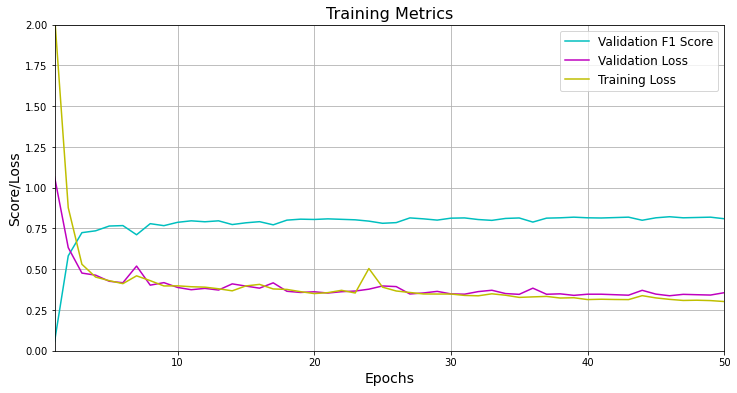

In [12]:
#let's plot some metrics, if you want to try others you can uncomment in the functions.py file
x_lim=50
y_lim=2
func.plot_history(history_simp_unet,x_lim, y_lim)

In comparation with the pretrained models it seems that the network it's a little bit simple for the problem (the training loss could be less) 

In [14]:
'''
ATTENTION
In "real life" it should not be used the test set for the model selection. 
is just to compare in this toy example
'''

print("Simp_UNET")
print("Validation results...")
model_simp_unet.evaluate(X_val, y_val)
print("Test results...")
model_simp_unet.evaluate(X_test, y_test) 

Simp_UNET
Validation results...
5/5 [==============================] - 2s 34ms/step - loss: 0.3568 - iou_score: 0.6838 - f1-score: 0.8117
Test results...
3/3 [==============================] - 2s 753ms/step - loss: 0.3785 - iou_score: 0.6600 - f1-score: 0.7951


[0.37846294045448303, 0.6599807143211365, 0.7951340079307556]